In [4]:
import numpy as np
from sklearn.datasets import load_svmlight_file
import urllib.request
import random
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import SGD, Adam

torch.set_default_dtype(torch.float64)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# np.random.seed(0)
# n = 10000
# d = 119
# A = np.random.randn(n,d)
# xopt = np.random.randn(d)
# b=np.dot(A,xopt)

# xopt = torch.Tensor(xopt)

In [4]:
# len(b)

10000

In [5]:
# b

array([-11.74892291,  -4.0134754 ,  -2.50353917, ...,   0.74194699,
        -7.42232615,   0.07158336])

In [6]:
# for i in range(len(b)):
#     if b[i]>0:
#         b[i]=1
#     else:
#         b[i]=-1

In [47]:
# b

array([-1., -1., -1., ...,  1., -1.,  1.])

In [7]:
# tA = torch.Tensor(A)
# tb = torch.Tensor(b)


In [4]:
def NLLSQ(w,X,y):
    return torch.mean(torch.square(y-1/(1+torch.exp(-X@w))))

In [6]:
def logreg(w, X, y):
    return torch.mean(torch.log(1 + torch.exp(-y * (X @ w))))

def grad_logreg(w, X, y):
    r = torch.exp(-y * (X @ w))
    return ( (r/(1 + r)) @ (X * -y[:, None]) ) / X.shape[0]

def hess_logreg(w, X, y):
    r = torch.exp(-y * (X @ w))
    return ( X.T @ (  (r/torch.square(1 + r)).reshape(-1, 1) * X ) ) / X.shape[0]

In [7]:
dataset_name = "mushrooms"
batch_size = 64
dataset_url = f"https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/{dataset_name}"
dataset_src = urllib.request.urlopen(dataset_url)
trainX, trainY = load_svmlight_file(dataset_src)
# trainX=tA
# trainY=tb


train_data = torch.tensor(trainX.toarray())
train_target = torch.tensor(trainY)

train_load = TensorDataset(train_data, train_target)
train_dataloader = DataLoader(train_load, batch_size=batch_size, shuffle=False)


scale = 5
r1 = -scale
r2 = scale
scaling_vec = (r1 - r2) * torch.rand(train_data.shape[1]) + r2
scaling_vec = torch.pow(torch.e, scaling_vec)
train_data_scaled = scaling_vec * train_data

train_load_scaled = TensorDataset(train_data_scaled, train_target)
train_dataloader_scaled = DataLoader(train_load_scaled, batch_size=batch_size, shuffle=False)

def fun(At,x,bt):
    return 1/2*torch.mean(torch.norm(At@x-bt)**2)

def dfun(At,x,bt):
    return At.T@(At@x-bt)
    
# def hessfun(At,x,bt):    
#     H=1/n*At.T@At

loss_function = logreg
loss_grad = grad_logreg
loss_hessian = hess_logreg



if loss_function == logreg:
    train_target[train_target == train_target.unique()[0]] = torch.tensor(-1.0, dtype=torch.get_default_dtype())
    train_target[train_target == train_target.unique()[1]] = torch.tensor(1.0, dtype=torch.get_default_dtype())
    assert torch.equal(train_target.unique(), torch.tensor([-1.0, 1.0]))


In [15]:
def rademacher_old(weights):
    return torch.round(torch.rand_like(weights)) * 2 - 1

def diag_estimate_old(weights, grad, iters):
    Ds = []
    for j in range(iters):
        z = rademacher_old(weights)
        with torch.no_grad():
            hvp = torch.autograd.grad(grad, weights, grad_outputs=z, retain_graph=True)[0]
        Ds.append((hvp*z))

    return torch.mean(torch.stack(Ds), 0)

def run_psps2(train_data, train_target, train_dataloader, epochs, precond_method="cg", **kwargs):

    torch.manual_seed(0)

    # parameters
    w = torch.zeros(train_data.shape[1], device=device).requires_grad_()

    # save loss and grad size to history
    hist = []


    loss = loss_function(w, train_data.to(device), train_target.to(device))
    g, = torch.autograd.grad(loss, w, create_graph=True)
    f_grad = g.clone().detach()


    if precond_method == "none":
        D = torch.ones_like(w)
    elif precond_method == "hutch":
        alpha=0.1
        beta=0.999
        init_iters = kwargs["hutch_init_iters"]
        Dk = diag_estimate_old(w, g, init_iters)
    elif precond_method == "cg" or precond_method == "pcg":
        s = torch.zeros_like(w) # s = H_inv * grad
        r = f_grad - torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]
        p = r.detach().clone()
        r_prev = torch.dot(r, r)
        MAX_ITER = train_data.shape[1] * 2
        # MAX_ITER = 1000

    elif precond_method == "scaling_vec":
        scaling_vec = kwargs["scaling_vec"]
        D = (1 / scaling_vec)**2
    elif precond_method == "adam" or precond_method == "adam_m":
        D = torch.zeros_like(g)
        v = torch.zeros_like(g)
        step_t = torch.tensor(0.)
        betas = (0.9, 0.999)
    elif precond_method == "adagrad" or precond_method == "adagrad_m":
        D = torch.zeros_like(g)
        v = torch.zeros_like(g)

    pcg_method = kwargs.get("pcg_method")
    if pcg_method == "hutch":
        alpha=0.1
        beta=0.999
        init_iters = kwargs["hutch_init_iters"]
        Dk_pcg = diag_estimate_old(w, g, init_iters)
    elif pcg_method == "adam":
        D_pcg = torch.zeros_like(g)
        v_pcg = torch.zeros_like(g)
        step_t_pcg = torch.tensor(0.)
        betas = (0.9, 0.999)
    elif pcg_method == "adagrad":
        D_pcg = torch.zeros_like(g)
        v_pcg = torch.zeros_like(g)
    elif pcg_method == None:
        D_pcg = torch.ones_like(g)

    cg_steps = []

    for epoch in range(epochs):

        loss = loss_function(w, train_data.to(device), train_target.to(device))
        g, = torch.autograd.grad(loss, w, create_graph=True)
        grad_norm_sq = torch.linalg.norm(g) ** 2
        acc = (np.sign(train_data @ w.detach().numpy()) == train_target).sum() / train_target.shape[0]

        print(f"[{epoch}/{epochs}] | Loss: {loss.item()} | GradNorm^2: {grad_norm_sq.item()} | Accuracy: {acc}")
        hist.append([loss.item(), grad_norm_sq.item(), acc])

        for i, (batch_data, batch_target) in enumerate(train_dataloader):

            loss = loss_function(w, batch_data, batch_target)
            g, = torch.autograd.grad(loss, w, create_graph=True)
            f_grad = g.detach().clone()
            # print("data",(batch_data))
            # ssstep = 1.0

            # if i % 1 == 0:
            #     loss = loss_function(w, train_data.to(device), train_target.to(device))
            #     g, = torch.autograd.grad(loss, w, create_graph=True)
            #     grad_norm_sq = torch.linalg.norm(g) ** 2
            #     print(f"[{epoch}][{i}] | Loss: {loss.item()} | GradNorm^2: {grad_norm_sq.item()} | Accuracy: {acc}")
            #     hist.append([loss.item(), grad_norm_sq.item(), acc])

            if precond_method == "hess_diag":
                hess = loss_hessian(w, batch_data, batch_target)
                hess_diag_inv = 1 / torch.diag(hess)
                s = hess_diag_inv * f_grad

            elif precond_method == "scaling_vec":
                s = D * f_grad

            elif precond_method == "adam" or precond_method == "adam_m":
                step_t += 1
                v = betas[1] * v + (1 - betas[1]) * g.square()
                v_hat = v / (1 - torch.pow(betas[1], step_t))

                if precond_method == "adam":
                    D = 1 / (torch.sqrt(v_hat) + 1e-6)
                elif precond_method == "adam_m":
                    D = 1 / (v_hat ) # NO SQRT ADAM
                s = D * f_grad

            elif precond_method == "adagrad" or precond_method == "adagrad_m":
                v.add_(torch.square(g))
                if precond_method == "adagrad":
                    D = 1 / (torch.sqrt(v) + 1e-6)
                elif precond_method == "adagrad_m":
                    D = 1 / (v ) # NO SQRT ADAGRAD
                s = D * f_grad

            elif precond_method == "none":
                s = D * f_grad

            elif precond_method == "hutch":
                vk = diag_estimate_old(w, g, 1)

                # Smoothing and Truncation
                Dk = beta * Dk + (1 - beta) * vk
                Dk_hat = torch.abs(Dk)
                Dk_hat[Dk_hat < alpha] = alpha

                D = 1 / Dk_hat
                s = D * f_grad

            # elif precond_method == "cg":

            #     trDelta = (loss / ( f_grad.dot(f_grad) )).item()
            #     print("trDelta",trDelta)

            #     # CG is here
            #     s = torch.zeros_like(w) # s = H_inv * grad
            #     z = torch.zeros_like(w)
            #     r = f_grad.clone()
            #     p = r.clone()
            
            #     for cg_step in range(MAX_ITER):
            #         hvp = torch.autograd.grad(g, w, grad_outputs=p, retain_graph=True)[0]
                    
            #         # print(torch.dot(p,hvp))
            #         if torch.dot(p,hvp)<=0:
            #             print("NEGATIFVE CURVATURE")
            #             # if cg_step==0:
            #             #     print("cg_step=0")
            #             #     s=p
            #             #     hvs = torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]
            #             #     ssstep=torch.dot(s,f_grad)/torch.dot(s,hvs)
            #             #     break
            #             # # print(cg_step)
            #             # print(torch.dot(p,hvp))
            #             # print("gp",torch.dot(p,tt))
                        
            #             if torch.dot(p,f_grad)<=0:
            #                 print("(p,f_grad)<=0")
                            
            #                 s=p
                                    
            #             else:
            #                 print("(p,f_grad)>0")
                            
            #                 s=-p
            #             hvs = torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]
            #             ssstep=torch.dot(s,f_grad)/torch.dot(s,hvs)
            #             break

                    
            #         # print(">",cg_step)
            #         # print(">",torch.dot(p,hvp))

            #         alpha_k = torch.dot(r, r) / torch.dot(p, hvp)
            #         z = z + alpha_k * p
            #         r_prev = r.clone()
            #         r = r - alpha_k * hvp
            #         # print(torch.norm(r))
            #         if torch.norm(r) < 1e-4:
            #             s=z
            #             hvs = torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]
            #             ssstep=torch.dot(s,f_grad)/torch.dot(s,hvs)
            #             # Ax = torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]
            #             # diff = torch.norm(Ax - f_grad)
            #             # print(f"CG Took {cg_step} to reach diff={diff}")
            #             # cg_steps.append(cg_step)
            #             break

            #         beta_k = torch.dot(r, r) / torch.dot(r_prev, r_prev)
                    
            #         p = r + beta_k * p
                        
                        


            elif precond_method == "pcg":

                if pcg_method == "hutch":
                    vk_pcg = diag_estimate_old(w, g, 1)
                    # Smoothing and Truncation
                    Dk_pcg = beta * Dk_pcg + (1 - beta) * vk_pcg
                    Dk_hat = torch.abs(Dk_pcg)
                    Dk_hat[Dk_hat < alpha] = alpha
                    D_pcg = 1 / Dk_hat
                elif pcg_method == "adam":
                    step_t_pcg += 1
                    v_pcg = betas[1] * v_pcg + (1 - betas[1]) * f_grad.square()
                    v_hat = v_pcg / (1 - torch.pow(betas[1], step_t_pcg))
                    # D_pcg = 1 / (torch.sqrt(v_hat) + 1e-6)
                    D_pcg = 1 / (v_hat + 1e-8)
                elif pcg_method == "adagrad":
                    v_pcg.add_(f_grad.square())
                    D_pcg = 1 / (v_pcg + 1e-8)
                elif pcg_method == "none":
                    D_pcg = torch.ones_like(f_grad)

                # hess = loss_hessian(w, batch_data, batch_target)
        
                # hess_diag_inv = 1 / torch.diag(hess)

                hess_diag_inv = D_pcg.clone()
                
            
                # Preconditioned CG is here
                s = torch.zeros_like(w) # s = H_inv * grad
                r = f_grad.clone()
                z = hess_diag_inv * r
                p = z.detach().clone()

                for cg_step in range(MAX_ITER):
                    hvp = torch.autograd.grad(g, w, grad_outputs=p, retain_graph=True)[0]
                    alpha_k = torch.dot(r, z) / torch.dot(p, hvp)
                    s = s + alpha_k * p
                    r_prev = r.clone()
                    r = r - alpha_k * hvp
                    # print(torch.dot(r,hess_diag_inv*r))
                    # if torch.norm(r)<1e-4:
                    if torch.dot(r,hess_diag_inv*r) < 1e-8:
                        # print("criteria",torch.dot(r,hess_diag_inv*r))
                        # print("s",s*scaling)
                        # Ax = torch.autograd.grad(g, w, grad_outputs=s, retain_graph=True)[0]
                        # diff = torch.norm(Ax - f_grad)
                        # print(f"PCG Took {cg_step} to reach diff={diff}")
                        # cg_steps.append(cg_step)
                        break

                    z_prev = z.clone()
                    z = hess_diag_inv * r
                    beta_k = torch.dot(r, z) / torch.dot(r_prev, z_prev)
                    p = z + beta_k * p
                    
               
            

            grad_norm_sq_scaled = torch.dot(f_grad, s)

            if 2 * loss <= grad_norm_sq_scaled:
                c = loss / ( grad_norm_sq_scaled )
                det = 1 - 2 * c
                if det < 0.0:
                    step_size = 1.0
                else:
                    step_size = 1 - torch.sqrt(det)
            else:
                # print(f"[{epoch}, {i}] No solution")
                step_size = 1.0

            # step_size = step_size*0.1
            
            # FB =  loss_function(w, train_data.to(device), train_target.to(device))
            # FBB =  loss_function(w, batch_data, batch_target)
            with torch.no_grad():
                w.sub_(step_size *s)
            # FA =  loss_function(w, train_data.to(device), train_target.to(device))
            # FAA =  loss_function(w, batch_data, batch_target)

            # print(FA - FB, " <<< 0", FAA - FBB)


    return hist

In [16]:
EPOCHS = 100

In [17]:
hist_cg = run_psps2(train_data, train_target, train_dataloader, EPOCHS, precond_method="pcg",pcg_method="adam")

[0/100] | Loss: 0.6931471805599453 | GradNorm^2: 0.31956696075430274 | Accuracy: 0.0
[1/100] | Loss: 0.049528951356467725 | GradNorm^2: 0.0023183219963415977 | Accuracy: 0.9864598719842442
[2/100] | Loss: 0.002371069670338787 | GradNorm^2: 5.258165486606457e-06 | Accuracy: 0.999015263417036


[3/100] | Loss: 0.0006506283446719446 | GradNorm^2: 2.0423145417064374e-06 | Accuracy: 0.9998769079271295
[4/100] | Loss: 0.0004735602098502571 | GradNorm^2: 1.2151025636147516e-06 | Accuracy: 0.9998769079271295
[5/100] | Loss: 0.00035707893783089794 | GradNorm^2: 7.307554957204778e-07 | Accuracy: 0.9998769079271295
[6/100] | Loss: 0.00021637207912261487 | GradNorm^2: 3.350321224454187e-07 | Accuracy: 0.9998769079271295
[7/100] | Loss: 0.00010177711147753833 | GradNorm^2: 1.2163003585926684e-07 | Accuracy: 1.0
[8/100] | Loss: 2.575406539527049e-05 | GradNorm^2: 1.1556375797693931e-08 | Accuracy: 1.0
[9/100] | Loss: 2.3926047240388526e-05 | GradNorm^2: 1.0377058700867007e-08 | Accuracy: 1.0
[10/100] | Loss: 1.4463691466324566e-05 | GradNorm^2: 4.022456147270445e-09 | Accuracy: 1.0
[11/100] | Loss: 1.1420479462334543e-05 | GradNorm^2: 2.5518829033784846e-09 | Accuracy: 1.0
[12/100] | Loss: 6.966997877381722e-06 | GradNorm^2: 9.639507410791503e-10 | Accuracy: 1.0
[13/100] | Loss: 7.569049

In [18]:
hist_cg_scaled = run_psps2(train_data_scaled, train_target, train_dataloader_scaled, EPOCHS, precond_method="pcg",pcg_method="adam")

[0/100] | Loss: 0.6931471805599453 | GradNorm^2: 56.29409977340585 | Accuracy: 0.0


[1/100] | Loss: 0.04850603394801116 | GradNorm^2: 1.4139010800737872 | Accuracy: 0.9883062530773018
[2/100] | Loss: 0.001737252717147592 | GradNorm^2: 0.0038038085115073713 | Accuracy: 0.999507631708518
[3/100] | Loss: 0.00039768481026551244 | GradNorm^2: 0.0007033891915071761 | Accuracy: 0.9998769079271295
[4/100] | Loss: 0.0002537158351714152 | GradNorm^2: 0.0003666338345615346 | Accuracy: 0.9998769079271295
[5/100] | Loss: 0.00020927716175760252 | GradNorm^2: 0.0002758304502589715 | Accuracy: 0.9998769079271295
[6/100] | Loss: 0.00014208516622159464 | GradNorm^2: 0.00016905356823645746 | Accuracy: 0.9998769079271295
[7/100] | Loss: 6.87200535798622e-05 | GradNorm^2: 5.6148738080832744e-05 | Accuracy: 1.0
[8/100] | Loss: 3.686574197605749e-05 | GradNorm^2: 1.872508152036592e-05 | Accuracy: 1.0
[9/100] | Loss: 2.5746891180193643e-05 | GradNorm^2: 9.75896871190742e-06 | Accuracy: 1.0
[10/100] | Loss: 2.4408300389695276e-05 | GradNorm^2: 8.843769216778854e-06 | Accuracy: 1.0
[11/100] | 

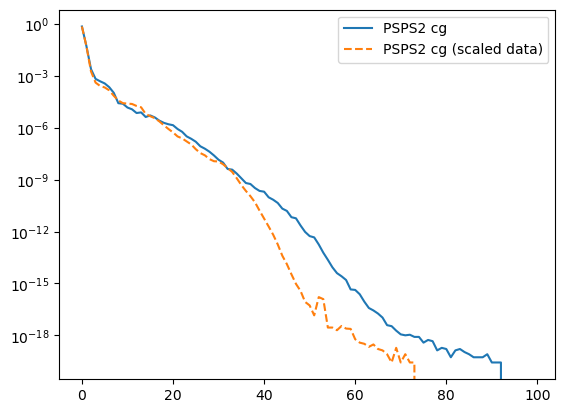

In [19]:
plt.semilogy([x[0] for x in hist_cg], label="PSPS2 cg")
plt.semilogy([x[0] for x in hist_cg_scaled], linestyle="--", label="PSPS2 cg (scaled data)")

plt.legend()

In [58]:
hist_adam_m = run_psps2(train_data, train_target, train_dataloader, EPOCHS, precond_method="adam_m")

[0/100] | Loss: 1.285942885278188 | GradNorm^2: 2.780539152370406 | Accuracy: 0.0


UnboundLocalError: local variable 'ssstep' referenced before assignment

In [ ]:
hist_adam_m_scaled = run_psps2(train_data_scaled, train_target, train_dataloader_scaled, EPOCHS, precond_method="adam_m")

[0/200] | Loss: 7134.183037412288 | GradNorm^2: 4189665362.3540506 | Accuracy: 0.0
[1/200] | Loss: 36726.765757789035 | GradNorm^2: 1731976887.294416 | Accuracy: 0.0
[2/200] | Loss: 32063.635434853688 | GradNorm^2: 665986914.1063794 | Accuracy: 0.0
[3/200] | Loss: 28555.169649375475 | GradNorm^2: 377413930.9972227 | Accuracy: 0.0
[4/200] | Loss: 25517.848310782654 | GradNorm^2: 280204745.7776257 | Accuracy: 0.0
[5/200] | Loss: 22723.56487405939 | GradNorm^2: 242272671.79482 | Accuracy: 0.0
[6/200] | Loss: 20113.091900933923 | GradNorm^2: 227474952.8862337 | Accuracy: 0.0
[7/200] | Loss: 17675.875692176352 | GradNorm^2: 222315568.92573893 | Accuracy: 0.0
[8/200] | Loss: 15411.763980316704 | GradNorm^2: 220669571.07369027 | Accuracy: 0.0
[9/200] | Loss: 13321.741689323635 | GradNorm^2: 219633153.3077289 | Accuracy: 0.0
[10/200] | Loss: 11406.186677310367 | GradNorm^2: 217846624.34642026 | Accuracy: 0.0
[11/200] | Loss: 9664.571265361486 | GradNorm^2: 214659458.95667353 | Accuracy: 0.0
[1

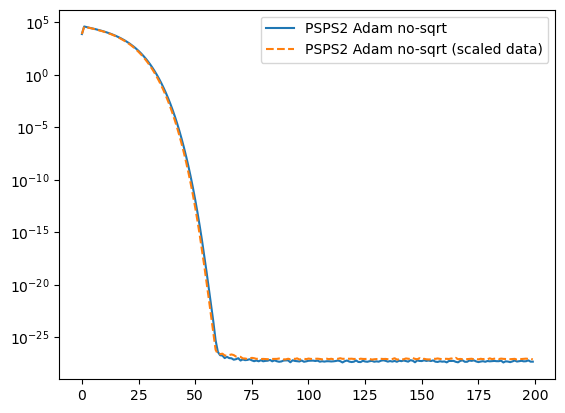

In [ ]:
plt.semilogy([x[0] for x in hist_adam_m], label="PSPS2 Adam no-sqrt")
plt.semilogy([x[0] for x in hist_adam_m_scaled], linestyle="--", label="PSPS2 Adam no-sqrt (scaled data)")

plt.legend()